# FFNN Classifier 3D (the proper version)

In [1]:
%matplotlib widget
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../iris.csv")
df['petal.dist'] = (df['petal.length']**2+df['petal.width']**2)**.5

In [3]:
features = ['sepal.length',
            'sepal.width',
            'petal.dist',]
labels   = 'variety'

nazvy premennych v zmysle konvencie: vstup [x] -> vystup [y]

pd.DataFrame.map(dictionary) -> zmena na ciselnu hondotu (index)

In [4]:
x = df[features]
y = df[labels]
d = {'Setosa' : 0,
     'Versicolor' : 1,
     'Virginica' : 2}
y = y.map(d)

In [5]:
# Vizualizacia modelu: v tomto pripade nezabavne.
# Pre vizualizaciu treba pydot, obsiahnuty v graphviz.
# Odkomentovat riadku
# V pripade zaujmu treba nainstalovat package podla OS:

#!winget install graphviz
#!sudo apt install graphviz
#!brew install graphviz

#!python -m pip install pydot
nbatch = 64
nepochs = 400

model = tf.keras.Sequential([
     tf.keras.Input(shape=(3)),
     tf.keras.layers.Dense(64, activation='gelu'),
     tf.keras.layers.Dense(64, activation='gelu'),
     tf.keras.layers.Dense(64, activation='gelu'),
     tf.keras.layers.Dense(64, activation='gelu'),
     tf.keras.layers.Dropout(0.5), # will come back to this
     tf.keras.layers.Dense(3, activation="softmax"),])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.build((nbatch,len(features)))
model.summary()
#tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 12931 (50.51 KB)
Trainable params: 12931 (50.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# tensorflow imprementacia funkcie onehot

np.shape(tf.keras.utils.to_categorical(y, num_classes=3))

(150, 3)

In [7]:
history = model.fit(x, tf.keras.utils.to_categorical(y, num_classes=3) , batch_size=nbatch, epochs=nepochs)

Epoch 1/400


3/3 [==============================] - 2s 5ms/step - loss: 1.1276 - accuracy: 0.3333
Epoch 2/400
3/3 [==============================] - 0s 3ms/step - loss: 0.9879 - accuracy: 0.3333
Epoch 3/400
3/3 [==============================] - 0s 3ms/step - loss: 0.9580 - accuracy: 0.3333
Epoch 4/400
3/3 [==============================] - 0s 3ms/step - loss: 0.9017 - accuracy: 0.4667
Epoch 5/400
3/3 [==============================] - 0s 3ms/step - loss: 0.8320 - accuracy: 0.6733
Epoch 6/400
3/3 [==============================] - 0s 3ms/step - loss: 0.7684 - accuracy: 0.7600
Epoch 7/400
3/3 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.8267
Epoch 8/400
3/3 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.7600
Epoch 9/400
3/3 [==============================] - 0s 3ms/step - loss: 0.5506 - accuracy: 0.7200
Epoch 10/400
3/3 [==============================] - 0s 3ms/step - loss: 0.4844 - accuracy: 0.8600
Epoch 11/400
3/3 [=========

numpy magic -> chceme jeden stlpec {pqr} obsahujuci vsetky body mriezky {p} x {q} x {r}

In [8]:
dp = 20
dq = 20
dr = 20

p = np.linspace(0.9*np.min(df['sepal.length']), 
                1.1*np.max(df['sepal.length']), dp)
q = np.linspace(0.9*np.min(df['sepal.width']), 
                1.1*np.max(df['sepal.width']), dq)
r = np.linspace(0.9*np.min(df['petal.dist']), 
                1.1*np.max(df['petal.dist']), dr) #r
pq = np.zeros((len(p)*len(q)*len(r), 3))
rs = np.zeros((len(p), len(q), len(r), 3))
for i in range(len(p)):
    for j in range(len(q)):
        for k in range(len(r)):
                pq[k + len(r)*(j + i*len(q))] = [p[i], q[j], r[k]]

In [9]:
# lebo DataFrame funguje, povodny numpy.ndarray protestoval
out = model.predict(pd.DataFrame(pq)) 

250/250 [==============================] - 0s 1ms/step


In [10]:
np.shape(out)

(8000, 3)

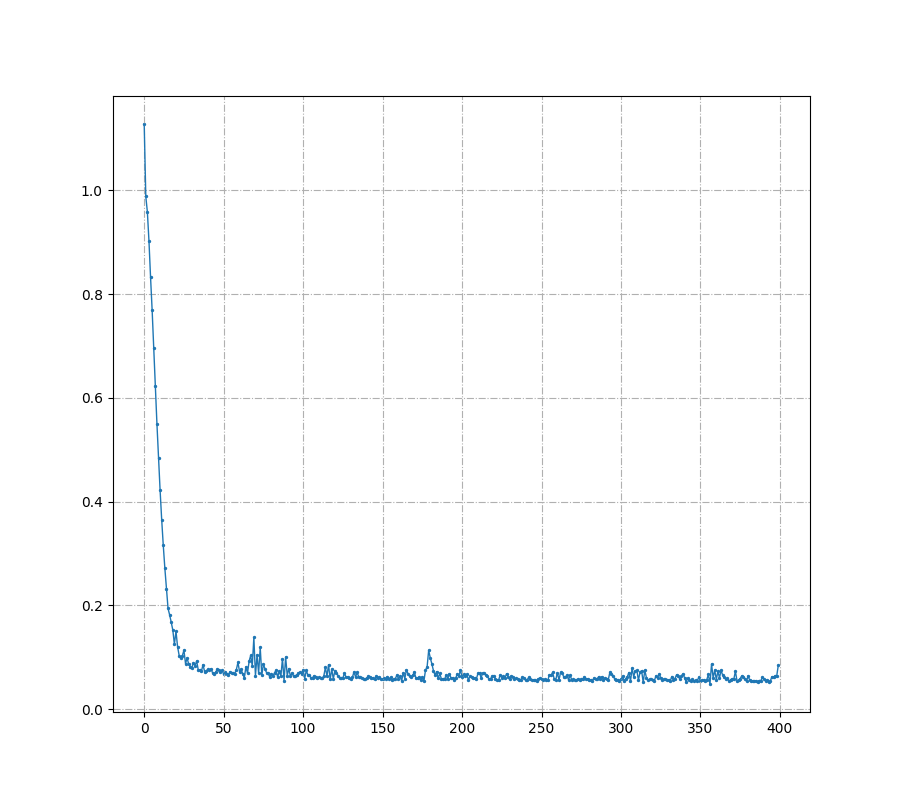

In [11]:
plt.figure(figsize=(9,8))
plt.grid(which='both', linestyle='dashdot')

plt.scatter(range(nepochs), history.history['loss'],s=2)
plt.plot(range(nepochs), history.history['loss'],linewidth=1)

plt.show()

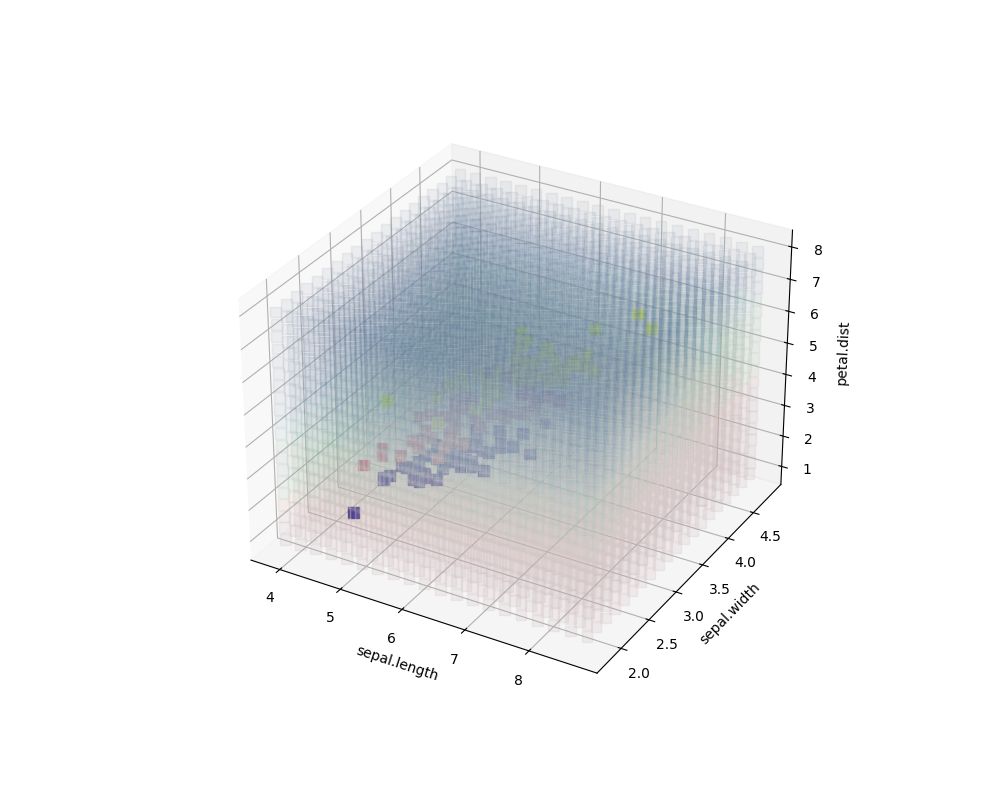

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
SCALE = 60
SATURATION = 0.05
CMAP = 'plasma'

px = df['sepal.length']
qx = df['sepal.width']
rx = df['petal.dist']
tx = df['variety']
tx = tx.map(d)

PX, QX, RX = np.meshgrid(p,q,r)

scatter= ax.scatter(px, qx, rx, s=SCALE, c=tx, 
                    cmap=CMAP, alpha=1,
                    marker='s')
# Znazornene ako RGB, kde jednotlive komponenty
# zodpovedaju modelom predpokladanej pravdepodobnosti
# vyskytu jednotlivych kvetov v danom bode.
TX = np.transpose(out)
cmaps   = ['Reds', 'Greens', 'Blues']
variety = ['Set', 'Vers', 'Virg']
for it in range(3): 
    txi =ax.scatter(PX, QX, RX, s=SCALE, c=TX[it],
            cmap=cmaps[it], alpha=SATURATION,
            marker='s')

    # Moc velke, maly graf
    #colorbar = plt.colorbar(txi)
    #colorbar.set_label(variety[it])

ax.set_xlabel("sepal.length")
ax.set_ylabel("sepal.width")
ax.set_zlabel("petal.dist")

plt.show()

In [13]:
TX0

array([9.9955148e-01, 9.9705291e-01, 9.7359294e-01, ..., 5.8873545e-11,
       9.7658487e-12, 2.0059076e-12], dtype=float32)